In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/radiolo/radiology_images/image_32415.jpg
/kaggle/input/radiolo/radiology_images/image_16454.jpg
/kaggle/input/radiolo/radiology_images/image_36989.jpg
/kaggle/input/radiolo/radiology_images/image_4378.jpg
/kaggle/input/radiolo/radiology_images/image_41366.jpg
/kaggle/input/radiolo/radiology_images/image_13094.jpg
/kaggle/input/radiolo/radiology_images/image_58146.jpg
/kaggle/input/radiolo/radiology_images/image_50895.jpg
/kaggle/input/radiolo/radiology_images/image_14675.jpg
/kaggle/input/radiolo/radiology_images/image_16443.jpg
/kaggle/input/radiolo/radiology_images/image_15181.jpg
/kaggle/input/radiolo/radiology_images/image_21821.jpg
/kaggle/input/radiolo/radiology_images/image_41501.jpg
/kaggle/input/radiolo/radiology_images/image_50320.jpg
/kaggle/input/radiolo/radiology_images/image_5576.jpg
/kaggle/input/radiolo/radiology_images/image_25303.jpg
/kaggle/input/radiolo/radiology_images/image_27710.jpg
/kaggle/input/radiolo/radiology_images/image_39148.jpg
/kaggle/inpu

In [2]:
!pip install rouge
!pip install --upgrade nltk rouge-score pycocoevalcap
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Dropout
from transformers import BlipProcessor, BlipForConditionalGeneration, get_linear_schedule_with_warmup
import pandas as pd
from PIL import Image
from tqdm import tqdm
from rouge import rouge
import random
import numpy as np
import gc
import logging
import os
from torchvision import transforms
from torch.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import seaborn as sns

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# Gradient Scaler for Mixed Precision
gc.collect()
scaler = torch.amp.GradScaler('cuda')
torch.cuda.empty_cache()

In [3]:
# Preprocess the dataset
class RadiologyDataset(Dataset):
    def __init__(self, csv_file, processor, max_length=512, image_size=224):
        self.data = pd.read_csv(csv_file)
        self.data = self.data.head(250)  # Using first 4 rows as requested
        self.processor = processor
        self.max_length = max_length
        self.image_size = image_size
        
        # Validate data
        self._validate_data()
        
    def _validate_data(self):
        """Validate and clean the dataset"""
        valid_rows = []
        for idx, row in self.data.iterrows():
            full_image_path = os.path.join("/kaggle/input/radiolo", row['image_file_path'])
            if os.path.exists(full_image_path) and pd.notna(row['label']):
                valid_rows.append(idx)
        self.data = self.data.iloc[valid_rows].reset_index(drop=True)
        print(f"Valid samples in dataset: {len(self.data)}")
    
    def _process_image(self, image_path):
        """Process and validate image"""
        try:
            image = Image.open(image_path).convert('RGB')
            transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ColorJitter(brightness=0.2, contrast=0.2)
            ])
            image = transform(image)
            return image.resize((self.image_size, self.image_size), Image.Resampling.LANCZOS)
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            return None
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        try:
            image_path =os.path.join("/kaggle/input/radiolo", self.data.iloc[idx]['image_file_path'])
            caption = str(self.data.iloc[idx]['label'])
            
            # Clean and validate caption
            caption = clean_caption(caption)
            if not caption:
                caption = "No findings."
            
            # Process image
            image = self._process_image(image_path)
            if image is None:
                raise ValueError(f"Failed to process image at index {idx}")
            
            # Create encoding with error checking
            encoding = self.processor(
                image, 
                caption,
                return_tensors="pt",
                padding="max_length",
                max_length=self.max_length,
                truncation=True
            )
            
            # Remove batch dimension and validate tensors
            for k, v in encoding.items():
                encoding[k] = v.squeeze()
                if torch.isnan(v).any():
                    raise ValueError(f"NaN values detected in {k} tensor")
            
            return encoding
        except Exception as e:
            print(f"Error processing item {idx}: {e}")
            raise


In [4]:
#Clean the captions produced
def clean_caption(caption):
    """Clean and validate caption text"""
    if not isinstance(caption, str):
        caption = str(caption)
    
    # Remove excessive whitespace
    caption = ' '.join(caption.split())
    # Remove non-printable characters
    caption = ''.join(char for char in caption if char.isprintable())
    # Ensure proper ending
    caption = caption.rstrip('.')
    if caption and not caption.endswith('.'):
        caption += '.'
    return caption

In [5]:
#Train the model
def train_model(
    csv_path="/kaggle/input/radiology/radiology_dataset.csv",
    device_type='auto',
    batch_size=25,
    num_epochs=17,
    learning_rate=2e-5,
    max_length=512,
    image_size=224,
    gradient_accumulation_steps=4
):
    # Clear GPU memory
    torch.cuda.empty_cache()
    gc.collect()
    
    # Set random seeds
    torch.manual_seed(23)
    random.seed(23)
    np.random.seed(23)
    
    # Determine device
    if device_type == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device_type)
    
    logger.info(f"Using device: {device}")
    
    try:
        # Initialize model and processor
        processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
        model = BlipForConditionalGeneration.from_pretrained(
            "Salesforce/blip-image-captioning-large",
            torch_dtype=torch.float32,  # Use full precision to avoid NaN
            low_cpu_mem_usage=True
        )
        model = model.to(device)
        model.gradient_checkpointing_enable()  # Enable gradient checkpointing
        
        # Create dataset and dataloaders
        dataset = RadiologyDataset(csv_path, processor, max_length, image_size)
        train_size = int(0.8 * len(dataset))  # 80% for training
        val_size = len(dataset) - train_size  # 20% for validation
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

        train_dataloader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,  # Avoid multiprocessing issues
            pin_memory=True if device.type == 'cuda' else False
        )
        
        val_dataloader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=True if device.type == 'cuda' else False
        )
        
        # Initialize optimizer with gradient clipping
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=0.01,
            eps=1e-8  # Increased epsilon for stability
        )
        
        # Learning rate scheduler
        num_training_steps = num_epochs * len(train_dataloader)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=learning_rate,
            total_steps=num_training_steps,
            pct_start=0.1,
            anneal_strategy='linear'
        )
        
        # Metrics storage
        metrics = {
            "train_loss": [],
            "val_loss": [],
            "train_accuracy": [],
            "val_accuracy": [],
            "learning_rate": [],
            "true_labels": [],
            "predicted_labels": []
        }
        
        # Training loop
        best_val_loss = float('inf')
        patience = 3
        no_improve = 0
        
        for epoch in range(num_epochs):
            train_loss = 0
            val_loss = 0
            correct_train_predictions = 0
            total_train_predictions = 0
            correct_val_predictions = 0
            total_val_predictions = 0
            
            # Training loop
            model.train()
            progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{num_epochs}")
            
            for batch_idx, batch in enumerate(progress_bar):
                try:
                    # Move batch to device
                    input_ids = batch["input_ids"].to(device)
                    pixel_values = batch["pixel_values"].to(device)
                    attention_mask = batch["attention_mask"].to(device)
                    
                    # Forward pass with mixed precision
                    with autocast("cuda"):  # Automatic mixed precision
                        outputs = model(
                            input_ids=input_ids,
                            pixel_values=pixel_values,
                            attention_mask=attention_mask,
                            labels=input_ids
                        )
                    
                    # Use the loss directly (No need for check_loss function)
                    loss_value = outputs.loss.item()
                    train_loss += loss_value
                    
                    # Log learning rate
                    metrics["learning_rate"].append(scheduler.get_last_lr()[0])
                    
                    # Backward pass with gradient clipping
                    scaler.scale(outputs.loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                    scheduler.step()
                    optimizer.zero_grad()
                    
                    # Predictions for accuracy
                    preds = outputs.logits.argmax(dim=-1)
                    correct_train_predictions += (preds == input_ids).sum().item()
                    total_train_predictions += input_ids.numel()

                    del outputs, loss_value
                    torch.cuda.empty_cache()
                    
                except Exception as e:
                    logger.error(f"Error in training batch {batch_idx}: {e}")
                    continue
            
            # Compute metrics for training epoch
            avg_train_loss = train_loss / len(train_dataloader)
            train_accuracy = correct_train_predictions / total_train_predictions if total_train_predictions > 0 else 0
            metrics["train_loss"].append(avg_train_loss)
            metrics["train_accuracy"].append(train_accuracy)
            
            print(f"Training Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
            
            # Validation loop
            model.eval()
            with torch.no_grad():
                for batch_idx, batch in enumerate(val_dataloader):
                    input_ids = batch["input_ids"].to(device)
                    pixel_values = batch["pixel_values"].to(device)
                    attention_mask = batch["attention_mask"].to(device)
                    
                    outputs = model(
                        input_ids=input_ids,
                        pixel_values=pixel_values,
                        attention_mask=attention_mask,
                        labels=input_ids
                    )
                    
                    val_loss = outputs.loss.item()
                    val_loss += val_loss
                    
                    # Predictions for accuracy
                    preds = outputs.logits.argmax(dim=-1)
                    correct_val_predictions += (preds == input_ids).sum().item()
                    total_val_predictions += input_ids.numel()
                    
            # Compute metrics for validation epoch
            avg_val_loss = val_loss / len(val_dataloader)
            val_accuracy = correct_val_predictions / total_val_predictions if total_val_predictions > 0 else 0
            metrics["val_loss"].append(avg_val_loss)
            metrics["val_accuracy"].append(val_accuracy)
            
            print(f"Validation Epoch {epoch+1}/{num_epochs}, Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
            
            # Save model if it improves
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                no_improve = 0
                model.save_pretrained("/kaggle/working/blip_radiology_finetuned")
                processor.save_pretrained("/kaggle/working/blip_radiology_finetuned")
            else:
                no_improve += 1
                if no_improve >= patience:
                    logger.info("Early stopping triggered")
                    break

            torch.cuda.empty_cache()
            gc.collect()
        
        # Plot metrics and evaluate
        plot_metrics(metrics)
        # ... inside train_model after the training loop ...
        bleu_score = evaluate_model(model, processor, val_dataloader, device) # Pass val_dataset here
        print(f"BLEU score on validation set: {bleu_score}")
        return model, processor, metrics
    
    except Exception as e:
        logger.error(f"Training failed: {e}")
        raise

In [6]:
# plotting the metrics
def plot_metrics(metrics):
    """Plot loss vs epochs, accuracy vs epochs, and learning rate vs epochs.""" 
    epochs = range(1, len(metrics["train_loss"]) + 1)
    
    # Plot Loss vs Epochs
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics["train_loss"], label="Train Loss", color='red')
    plt.plot(epochs, metrics["val_loss"], label="Validation Loss", color='blue')
    plt.title("Loss vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot Accuracy vs Epochs
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics["train_accuracy"], label="Train Accuracy", color='green')
    plt.plot(epochs, metrics["val_accuracy"], label="Validation Accuracy", color='orange')
    plt.title("Accuracy vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot Learning Rate vs Epochs
    plt.figure(figsize=(10, 6))
    plt.plot(metrics["learning_rate"], label="Learning Rate", color='purple')
    plt.title("Learning Rate vs Epochs")
    plt.xlabel("Steps")
    plt.ylabel("Learning Rate")
    plt.legend()
    plt.grid(True)
    plt.show()


In [7]:
#Evaluation of the model
def evaluate_model(model, processor, dataloader, device):
    """Evaluate model and generate BLEU score with smoothing."""
    model.eval()
    predictions = []
    references = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            pixel_values = batch["pixel_values"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                pixel_values=pixel_values,
                attention_mask=attention_mask
            )
            
            logits = outputs.logits
            predicted_ids = logits.argmax(dim=-1).cpu().numpy()
            predicted_captions = [processor.decode(ids, skip_special_tokens=True) for ids in predicted_ids]
            true_captions = [processor.decode(ids, skip_special_tokens=True) for ids in input_ids.cpu().numpy()]
            
            predictions.extend(predicted_captions)
            references.extend(true_captions)
    
    # Compute BLEU with smoothing
    smoothing_function = SmoothingFunction().method1
    bleu_score = corpus_bleu(
        [[ref.split()] for ref in references], 
        [pred.split() for pred in predictions], 
        smoothing_function=smoothing_function
    )
    
    # Compute ROUGE
    rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {
        "rouge1": [],
        "rouge2": [],
        "rougeL": []
    }
    for ref, pred in zip(references, predictions):
        scores = rouge_scorer_obj.score(ref, pred)
        for metric in rouge_scores:
            rouge_scores[metric].append(scores[metric].fmeasure)
    avg_rouge_scores = {metric: np.mean(scores) for metric, scores in rouge_scores.items()}
    
    # Print evaluation metrics
    print("Evaluation Metrics:")
    print(f"BLEU: {bleu_score:.4f}")
    print(f"ROUGE-1: {avg_rouge_scores['rouge1']:.4f}")
    print(f"ROUGE-2: {avg_rouge_scores['rouge2']:.4f}")
    print(f"ROUGE-L: {avg_rouge_scores['rougeL']:.4f}")

    return {
        "BLEU": bleu_score,
        "ROUGE": avg_rouge_scores
    } 


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Valid samples in dataset: 250


Training Epoch 1/17:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Training Epoch 1/17: 100%|██████████| 8/8 [01:33<00:00, 11.74s/it]


Training Epoch 1/17, Loss: 10.2662, Accuracy: 0.0020
Validation Epoch 1/17, Loss: 10.0606, Accuracy: 0.0022


Training Epoch 2/17:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Training Epoch 2/17: 100%|██████████| 8/8 [01:33<00:00, 11.68s/it]


Training Epoch 2/17, Loss: 10.0249, Accuracy: 0.0017
Validation Epoch 2/17, Loss: 9.7162, Accuracy: 0.0004


Training Epoch 3/17:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Training Epoch 3/17: 100%|██████████| 8/8 [01:33<00:00, 11.73s/it]


Training Epoch 3/17, Loss: 8.9574, Accuracy: 0.0004
Validation Epoch 3/17, Loss: 8.1559, Accuracy: 0.0003


Training Epoch 4/17:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Training Epoch 4/17: 100%|██████████| 8/8 [01:33<00:00, 11.64s/it]


Training Epoch 4/17, Loss: 7.7918, Accuracy: 0.0018
Validation Epoch 4/17, Loss: 7.4077, Accuracy: 0.0020


Training Epoch 5/17:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Training Epoch 5/17: 100%|██████████| 8/8 [01:31<00:00, 11.42s/it]


Training Epoch 5/17, Loss: 7.1690, Accuracy: 0.0014
Validation Epoch 5/17, Loss: 6.9076, Accuracy: 0.0002


Training Epoch 6/17:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Training Epoch 6/17: 100%|██████████| 8/8 [01:30<00:00, 11.37s/it]


Training Epoch 6/17, Loss: 6.7046, Accuracy: 0.0002
Validation Epoch 6/17, Loss: 6.4967, Accuracy: 0.0003


Training Epoch 7/17:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Training Epoch 7/17: 100%|██████████| 8/8 [01:29<00:00, 11.24s/it]


Training Epoch 7/17, Loss: 6.3174, Accuracy: 0.0004
Validation Epoch 7/17, Loss: 6.1478, Accuracy: 0.0007


Training Epoch 8/17:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Training Epoch 8/17: 100%|██████████| 8/8 [01:31<00:00, 11.47s/it]


Training Epoch 8/17, Loss: 5.9858, Accuracy: 0.0006
Validation Epoch 8/17, Loss: 5.8454, Accuracy: 0.0006


Training Epoch 9/17:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Training Epoch 9/17: 100%|██████████| 8/8 [01:30<00:00, 11.32s/it]


Training Epoch 9/17, Loss: 5.6953, Accuracy: 0.0014
Validation Epoch 9/17, Loss: 5.5814, Accuracy: 0.0012


Training Epoch 10/17:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Training Epoch 10/17: 100%|██████████| 8/8 [01:32<00:00, 11.56s/it]


Training Epoch 10/17, Loss: 5.4419, Accuracy: 0.1373
Validation Epoch 10/17, Loss: 5.3512, Accuracy: 0.2039


Training Epoch 11/17:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Training Epoch 11/17: 100%|██████████| 8/8 [01:31<00:00, 11.45s/it]


Training Epoch 11/17, Loss: 5.2232, Accuracy: 0.3804
Validation Epoch 11/17, Loss: 5.1549, Accuracy: 0.7315


Training Epoch 12/17:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Training Epoch 12/17: 100%|██████████| 8/8 [01:30<00:00, 11.28s/it]


Training Epoch 12/17, Loss: 5.0378, Accuracy: 0.8325
Validation Epoch 12/17, Loss: 4.9927, Accuracy: 0.8825


Training Epoch 13/17:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Training Epoch 13/17: 100%|██████████| 8/8 [01:29<00:00, 11.17s/it]


Training Epoch 13/17, Loss: 4.8852, Accuracy: 0.9237
Validation Epoch 13/17, Loss: 4.8584, Accuracy: 0.8976


Training Epoch 14/17:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Training Epoch 14/17: 100%|██████████| 8/8 [01:30<00:00, 11.29s/it]


Training Epoch 14/17, Loss: 4.7642, Accuracy: 0.9296
Validation Epoch 14/17, Loss: 4.7580, Accuracy: 0.9167


Training Epoch 15/17:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Training Epoch 15/17: 100%|██████████| 8/8 [01:30<00:00, 11.33s/it]


Training Epoch 15/17, Loss: 4.6745, Accuracy: 0.9320
Validation Epoch 15/17, Loss: 4.6866, Accuracy: 0.9182


Training Epoch 16/17:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Training Epoch 16/17: 100%|██████████| 8/8 [01:29<00:00, 11.19s/it]


Training Epoch 16/17, Loss: 4.6149, Accuracy: 0.9322
Validation Epoch 16/17, Loss: 4.6453, Accuracy: 0.9182


Training Epoch 17/17:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Training Epoch 17/17: 100%|██████████| 8/8 [01:29<00:00, 11.15s/it]


Training Epoch 17/17, Loss: 4.5852, Accuracy: 0.9323
Validation Epoch 17/17, Loss: 4.6326, Accuracy: 0.9182


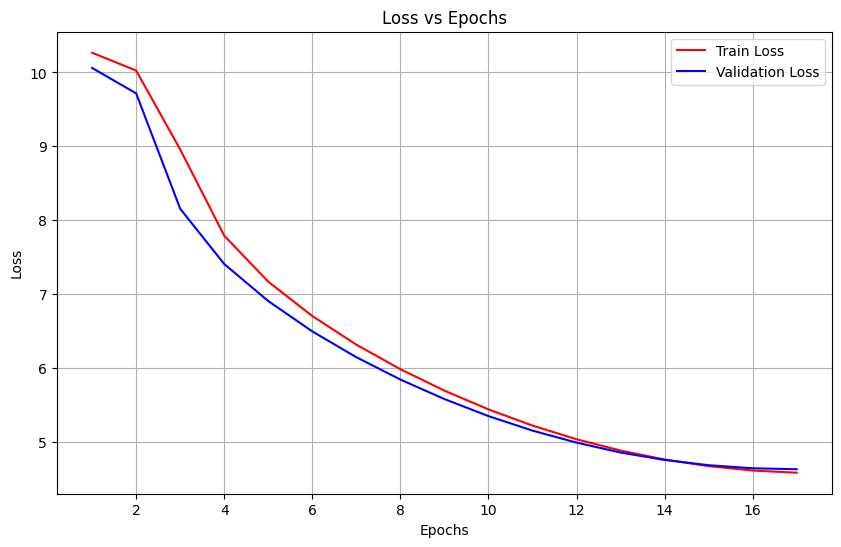

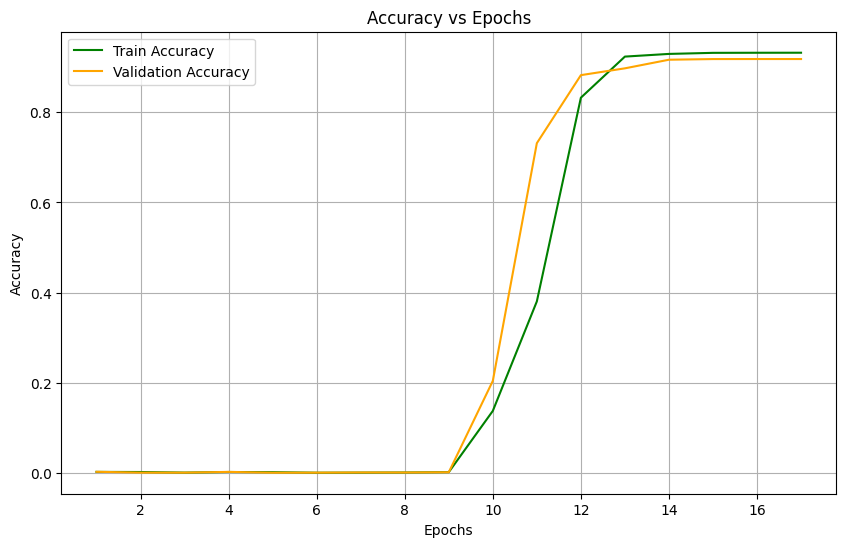

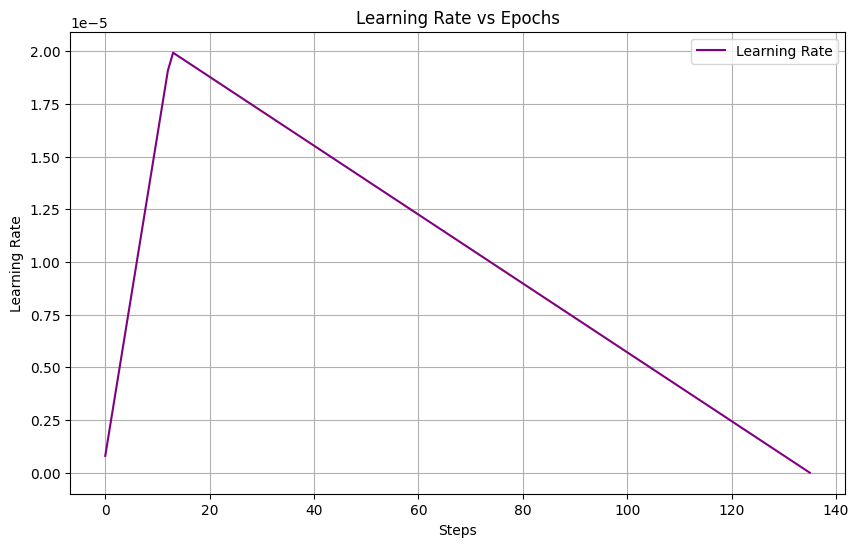

Evaluation Metrics:
BLEU: 0.0225
ROUGE-1: 0.2850
ROUGE-2: 0.0677
ROUGE-L: 0.2489
BLEU score on validation set: {'BLEU': 0.02247604924953345, 'ROUGE': {'rouge1': 0.2850261780586041, 'rouge2': 0.06768180116422859, 'rougeL': 0.24886318156471623}}


In [8]:
### Main function
def main():

    """Main function to start the training process.""" 
    train_model(
        csv_path="/kaggle/input/radiology/radiology_dataset.csv",
        device_type='auto',
        batch_size=25,
        num_epochs=17,
        learning_rate=2e-5,
        max_length=512,
        image_size=224,
        gradient_accumulation_steps=4
    )

if __name__ == "__main__":
    main()